In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random 
from pyvis.network import Network
import itertools
from scipy import optimize
import time

In [9]:
adj_matrix = np.zeros((100, 100))
possible_edges = [(i, j) for i in range(100) for j in range(100) if i < j ]
random.seed(42)
for k in random.sample(possible_edges, 4000):
    adj_matrix[k[0]][k[1]], adj_matrix[k[1]][k[0]] = np.random.randint(1, 50, size=2)
    
G = nx.from_numpy_matrix(adj_matrix)

In [34]:
nt = Network("600px", "600px", notebook=True, bgcolor="#222222", font_color="#FFFFFF", layout=nt.barnes_hut(), 
             heading='Undirected weighted graph')
nt.from_nx(G)
nt.toggle_physics(False)
nt.show("network_10.html")

# Prim's algorithm

In [4]:
def prim(G, source=0):
    tree = [source]
    edges = []
    graph = list(set(range(len(G.nodes()))) - set(tree))
    s = 0
    while graph:
        u = min([(tree_node, graph_node, dict(G.adjacency())[tree_node][graph_node]['weight']) 
                 for tree_node in tree for graph_node in graph 
                 if (tree_node, graph_node) in G.edges()], key=lambda x:x[2])
        tree.append(graph.pop(graph.index(u[1])))
        edges.append((u[0], u[1]))
        s += u[2]
    return {'min spanning tree': edges, 'weight': s}

In [5]:
prim(G)

{'min spanning tree': [(0, 3),
  (3, 9),
  (9, 1),
  (9, 5),
  (5, 8),
  (5, 6),
  (6, 2),
  (3, 4),
  (8, 7)],
 'weight': 113.0}

In [103]:
prim(G)['min spanning tree'] == list(nx.algorithms.tree.minimum_spanning_edges(G, algorithm="prim", data=False))

True

In [6]:
def time_meas(method, *args, nit=10):
    timings = []
    for i in range(nit):
        st = time.time()
        res = method(*args)
        timings.append(time.time() - st)
    return np.mean(timings)

In [99]:
time_meas(prim, G, nit=20)

0.8062932610511779

# Whale optimization algorithm
Mirjalili, S., & Lewis, A. (2016). The whale optimization algorithm. Advances in engineering software, 95, 51-67.

In [35]:
class Whale(object):
    nit = 0
    @classmethod
    def stop_counter(cls):
        cls.nit = 0
    def __init__(self, args, a=0, A=0, C=0, l=0, f=np.inf):
        self.coord = np.array(args)
        self.a, self.A, self.C, self.l, self.f = a, A, C, l, f
        self.__n_coords = len(args)
    def random(self, low=-10, up=10):
        self.coord = tuple(np.random.uniform(low, up, size=self.__n_coords))
        
    def update(self, maxiter):
        self.a = np.full(self.__n_coords, 2 - self.nit / maxiter)
        self.A = 2 * np.array(self.a) * np.random.uniform(0, 1, size=self.__n_coords) - np.array(self.a)
        self.C = 2 * np.random.uniform(0, 1, size=self.__n_coords)
        self.l = np.random.uniform(-1, 1)
        self.p = np.random.uniform(0, 1)
    
    def evaluate(self, fitnessFunc):
        self.f = fitnessFunc(self.coord)


In [36]:
class WOA():
    def __init__(self, fitnessFunc, bounds, num_whales=50, maxiter=1000):
        num_dimensions = len(bounds)
        
        self.x = None
        self.fun = None
        self.nit = 0
        # initializing the whales population
        whales = [Whale([np.random.uniform(bounds[i][0], bounds[i][1]) 
                         for i in range(num_dimensions)]) for _ in range(num_whales)]
        f_best_search_agent = whales[0].f
        x_best_search_agent = whales[0].coord
        for whale in whales:
            whale.evaluate(fitnessFunc)
            if whale.f < f_best_search_agent:
                f_best_search_agent = whale.f
                x_best_search_agent = whale.coord
        
        Whale.stop_counter() #reset the counter

        # main search cycle 
        # source of algorithm: 
        # Mirjalili, S., & Lewis, A. (2016). The whale optimization algorithm. 
        # Advances in engineering software, 95, 51-67.
        while Whale.nit < maxiter:
            for whale in whales:
                whale.update(maxiter)
                if whale.p < 0.5:
                    if np.linalg.norm(whale.A) < 1:
                        D = np.abs(whale.C * x_best_search_agent - whale.coord)
                        whale.coord = x_best_search_agent - whale.A * D
                        
                    else:
                        D = np.abs(whale.C * whales[np.random.randint(num_whales)].coord - whale.coord)
                        whale.coord = whales[np.random.randint(num_whales)].coord - whale.A * D
                else:
                    D = np.abs(x_best_search_agent - whale.coord)
                    whale.coord = D * np.exp(100 * whale.l) * np.cos(2 * np.pi * whale.l) + x_best_search_agent
            # check if all whales located within the bounds and change coordinate if not
            for whale in whales:
                c = np.where(np.array([bounds[i][0] <= whale.coord[i] <= bounds[i][1] 
                                       for i in range(num_dimensions)]) == False)
                for coor in c[0]:
                    whale.coord[coor] = np.random.uniform(*bounds[coor])
                # update best positions
                whale.evaluate(fitnessFunc)      
                if whale.f < f_best_search_agent:
                    f_best_search_agent = whale.f
                    x_best_search_agent = whale.coord
            Whale.nit += 1
        self.x = x_best_search_agent
        self.fun = f_best_search_agent
        self.nit = Whale.nit
        print('\n', 'x = ', self.x, '\n', 'fun = ', self.fun,'\n', 'nit = ', self.nit)

In [100]:
def f(args):
    return args[0] ** 2 + 3 * args[1] + 4 + args[0] * args[1] ** 2 + args[1] ** 4

In [38]:
res_WOA = WOA(f, list(zip([-10] * 2, [10] * 2)), num_whales=30, maxiter=1000)
res_SA = optimize.dual_annealing(f, list(zip([-10] * 2, [10] * 2)), maxiter=1000)


 x =  [-0.49999743 -0.99991659] 
 fun =  1.7500000378437988 
 nit =  1000


In [49]:
def f1(args):
    c = (args[1] - (5.1/(4*np.pi**2)) * args[0]**2 + (5/np.pi)*args[0] - 6)**2
    return c + 10*(1-(1/(8*np.pi))) * np.cos(args[0]) + 10

In [50]:
res_SA1 = optimize.dual_annealing(f1, list(zip([-5] * 2, [5] * 2)), maxiter=1000)
res_WOA1 = WOA(f1, list(zip([-5] * 2, [5] * 2)), num_whales=30, maxiter=1000)


 x =  [3.14229455 2.27427919] 
 fun =  0.3978897531143506 
 nit =  1000


In [90]:
def D_lin(args):
    return sum([(args[0]*data[k][0] + args[1] - data[k][1])**2 for k in range(len(data))])
    
def D_rat(args):
    return sum([(args[0] / (1.0 + data[k][0] * args[1]) - data[k][1])**2 for k in range(len(data))])
alpha = np.random.uniform(0, 1)
beta = np.random.uniform(0, 1)
data = [(k/100, alpha*k/100 + beta + np.random.normal(0, 1)) for k in range(101)]

Text(0.5, 1.0, 'Generated data')

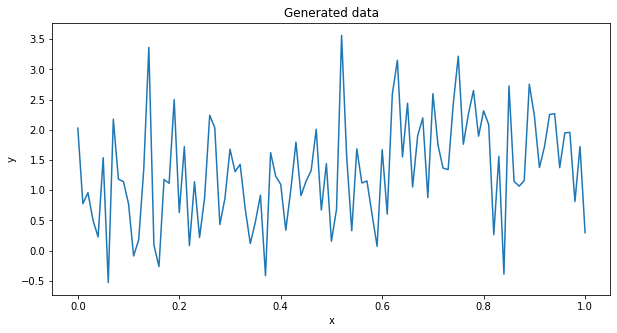

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*data))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated data')

In [92]:
res_WOA2 = WOA(D_lin, list(zip([-10] * 2, [10] * 2)), num_whales=30, maxiter=1000)
res_SA2 = optimize.dual_annealing(D_lin, list(zip([-10] * 2, [10] * 2)), maxiter=1000)


 x =  [1.00906205 0.82311583] 
 fun =  68.98795763173987 
 nit =  1000


In [93]:
res_WOA3 = WOA(D_rat, list(zip([-10] * 2, [10] * 2)), num_whales=30, maxiter=1000)
res_SA23 = optimize.dual_annealing(D_rat, list(zip([-10] * 2, [10] * 2)), maxiter=1000)


 x =  [ 0.97291908 -0.48466792] 
 fun =  69.71797048697977 
 nit =  1000


Text(0.5, 1.0, 'Data linear approximation')

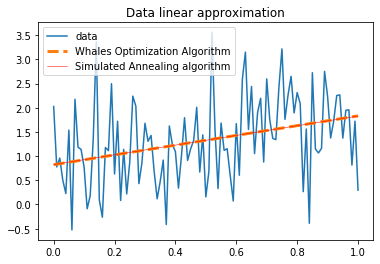

In [94]:
x = [k/100 for k in range(101)]
y = [res_WOA2.x[0] * (x/100) + res_WOA2.x[1] for x in range(101)]
y1 = [res_SA2.x[0] * (x/100) + res_SA2.x[1] for x in range(101)]
plt.plot(*zip(*data))
plt.plot(x, y, linewidth=3, linestyle='dashed')
plt.plot(x, y1, 'r', linewidth=0.5)
plt.legend(('data',  'Whales Optimization Algorithm', 'Simulated Annealing algorithm'))
plt.title('Data linear approximation')

Text(0.5, 1.0, 'Data rational approximation')

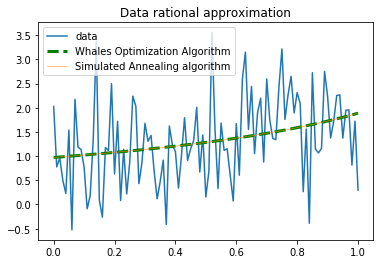

In [95]:
x2 = [k/100 for k in range(101)]
y2 = [res_WOA3.x[0]  / (res_WOA3.x[1] * (x/100) + 1) for x in range(101)]
y3 = [res_SA23.x[0]  / (res_SA23.x[1] * (x/100) + 1) for x in range(101)]
plt.plot(*zip(*data))
plt.plot(x2, y2, 'g', linewidth=3, linestyle='dashed')
plt.plot(x2, y3, linewidth=0.5)

plt.legend(('data', 'Whales Optimization Algorithm', 'Simulated Annealing algorithm'))
plt.title('Data rational approximation')